In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import tensorflow as tf
import numpy as np
import gpflow

from tueplots import bundles

from rcgp.rcgp import RCGPR
from rcgp.w import IMQ

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

2023-10-24 02:17:43.462704: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-10-24 02:17:43.462724: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-24 02:17:43.462735: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-24 02:17:43.462954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-24 02:17:43.463284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(0.0, 20.0)

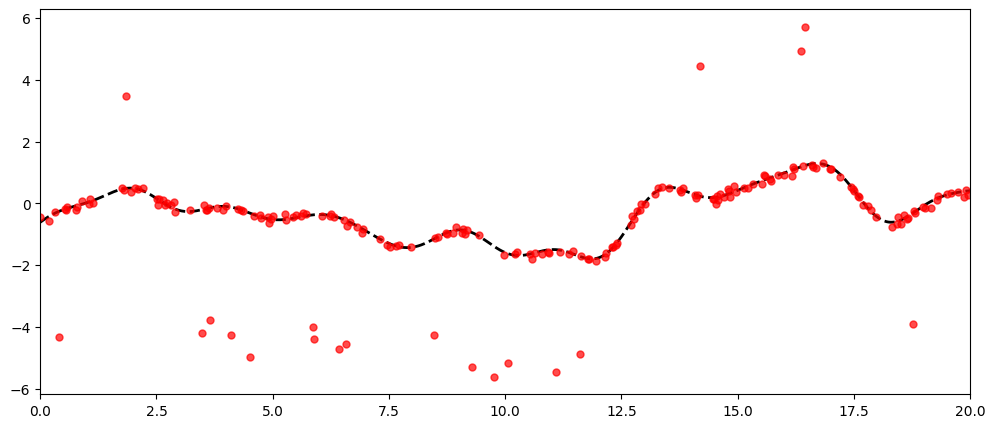

In [3]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

n_points = 1000
sigma_n = 0.1
percent = 0.2
percent_miss = 0.1

lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_obs, 1), int(percent_miss * n_obs), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [4]:
def median_absolute_deviation(Y):
    return np.median(abs(Y))

In [5]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)

In [6]:
# plot estimation, obs and real data
dsm_gp = RCGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    weighting_function= IMQ(C=np.quantile(np.abs(y_obs), 0.7)),
    noise_variance=sigma_n**2 
)

f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)

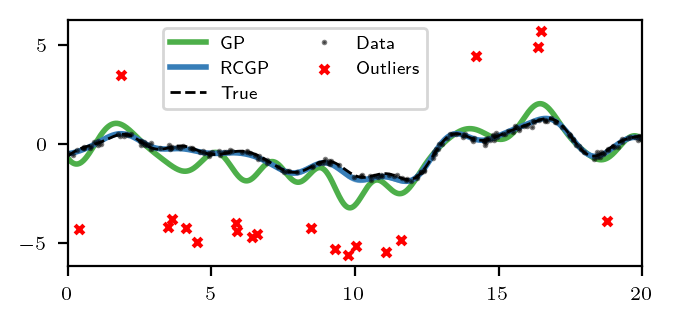

In [7]:
with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(figsize=(3.25, 1.5), dpi = 200)
    ax.plot(x[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=2, label= 'GP')
    ax.fill_between(
        x[:,0],
        f_mean[:,0] - 1.96 * f_std[:,0],
        f_mean[:,0] + 1.96 * f_std[:,0],
        facecolor= CB_color_cycle[2],
        alpha=0.5)
    ax.plot(x[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], lw=2, label= 'RCGP')
    ax.fill_between(
        x[:,0],
        f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
        f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
        facecolor= CB_color_cycle[0],
        alpha=0.5)
    ax.plot(x, f, color='black', ls='--', lw=1, label='True')
    ax.plot(x_obs[np.setdiff1d(np.arange(len(x_obs)),i_mis)] , y_obs[np.setdiff1d(np.arange(len(x_obs)),i_mis)], 'k.', ms=2, alpha=0.5, label = 'Data')
    ax.scatter(x_obs[i_mis] , y_obs[i_mis], marker = 'x', alpha=1, color= 'r', s=10, label = 'Outliers')
    ax.set_xlim(x[0], x[-1])
    plt.legend(ncol=2, fontsize = 6.5, bbox_to_anchor=(0.15,0.6))
    fig.savefig('figures/synthetic.pdf', format="pdf", bbox_inches= "tight")